<a href="https://colab.research.google.com/github/lena261/wiatr/blob/main/dane_wiatr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Energetyka wiatrowa, mimo swojej ekologiczności i niskich kosztów krańcowych, charakteryzuje się dużą niestabilnością i zależnością od warunków pogodowych, co ma kluczowe znaczenie dla bezpieczeństwa energetycznego.

Przedmiot analizy
Analizie poddano rzeczywiste dane dotyczące sumarycznej generacji źródeł wiatrowych w Krajowym Systemie Elektroenergetycznym (KSE). Dane obejmują okres od stycznia 2021 roku do czerwca 2024 roku z rozdzielczością godzinową.

Głównym celem projektu jest stworzenie modelu predykcyjnego, który na podstawie danych historycznych pozwoli oszacować przyszłą produkcję energii.

Hipoteza: Produkcja energii wiatrowej w Polsce wykazuje silną sezonowość roczną, z maksimami w okresie jesienno-zimowym i minimami w okresie letnim oraz ze względu na rozwój infrastruktury, w danych widoczny jest trend wzrostowy.

Dane:
Podstawą analizy są dane historyczne pochodzące z oficjalnych raportów dobowych publikowanych przez Polskie Sieci Elektroenergetyczne S.A. (PSE), pełniące funkcję Operatora Systemu Przesyłowego (OSP) w Polsce.

Dane zostały pobrane z sekcji Strona Główna>Dane systemowe>Raporty historyczne>Praca KSE>Funkcjonowanie KSE>Raporty dobowe z pracy KSE>Generacja źródeł wiatrowych i fotowoltaicznych. Są to dane publicznie dostępne, służące do monitorowania bilansu energetycznego kraju (zgodnie z zasadami przejrzystości rynku energii).

link: https://www.pse.pl/dane-systemowe/funkcjonowanie-kse/raporty-dobowe-z-pracy-kse/generacja-zrodel-wiatrowych

Zakres i struktura danych

Okres analizy: Dane obejmują okres od 1 stycznia 2022 r. do 13 czerwca 2024 r.

Rozdzielczość czasowa: Dane mają charakter godzinowy. Dla każdego dnia dostępnych jest 24 odczytów (lub 23/25 w dniach zmiany czasu), co łącznie daje ponad 21 000 punktów pomiarowych.

Format surowy: Dane źródłowe zostały pobrane w formacie .csv. Każdy plik odpowiadał jednemu miesiącowi kalendarzowemu, co wymagało procesu agregacji.

Zmienna celu: Główną analizowaną zmienną jest Generacja źródeł wiatrowych, wyrażona w megawatogodzinach [MWh]. Reprezentuje ona sumaryczną energię wprowadzoną do sieci przez wszystkie farmy wiatrowe w Polsce w danej godzinie.

wstep, tworzenie jednego pliku danych

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error
import glob
import seaborn as sns

# ŁĄCZENIE WSZYSTKICH PLIKÓW MEGA WAŻNE
print("Łączenie danych...")
all_files = glob.glob("*.csv")

li = []
for filename in all_files:
    try:
        df_part = pd.read_csv(filename, sep=';', encoding='cp1250', dtype=str)
        li.append(df_part)
    except:
        pass

if len(li) > 0:
    df = pd.concat(li, axis=0, ignore_index=True)

    # czyszczenie
    col_wiatr = 'Generacja źródeł wiatrowych'
    # zamiana przecinka na kropkę
    df[col_wiatr] = df[col_wiatr].str.replace(',', '.', regex=False)
    df[col_wiatr] = pd.to_numeric(df[col_wiatr], errors='coerce')

    #tworzenie daty
    df['Godzina'] = pd.to_numeric(df['Godzina'], errors='coerce').fillna(0).astype(int)
    df = df.dropna(subset=[col_wiatr])
    df['Data'] = pd.to_datetime(df['Data'])
    df['Data_Godz'] = df['Data'] + pd.to_timedelta(df['Godzina'] - 1, unit='h')

    df.set_index('Data_Godz', inplace=True)
    df = df.sort_index()
    df = df[[col_wiatr]].copy()
    df.columns = ['Produkcja_MWh']

    print(f"Mam dane od {df.index.min()} do {df.index.max()}")

    nazwa_pliku = 'polaczone_dane_wiatrowe.csv'
    df.to_csv(nazwa_pliku)
    print(f"Zapisano wszystko do pliku: {nazwa_pliku}")

else:
    print("BŁĄD: Nie znaleziono plików.")

Łączenie danych...
Mam dane od 2021-01-01 00:00:00 do 2024-06-13 23:00:00
Zapisano wszystko do pliku: polaczone_dane_wiatrowe.csv


In [3]:
df = pd.read_csv('polaczone_dane_wiatrowe.csv', parse_dates=True, index_col=0)

print(df.head())

                     Produkcja_MWh
Data_Godz                         
2021-01-01 00:00:00        543.900
2021-01-01 01:00:00        474.300
2021-01-01 02:00:00        428.838
2021-01-01 03:00:00        438.288
2021-01-01 04:00:00        432.288


In [4]:
# Ustawienie stylu wykresów
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

wykresy dla zobrazowania danych

/tmp/ipython-input-688195879.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Miesiac', y='Produkcja_MWh', data=df, ax=ax2, palette="coolwarm")


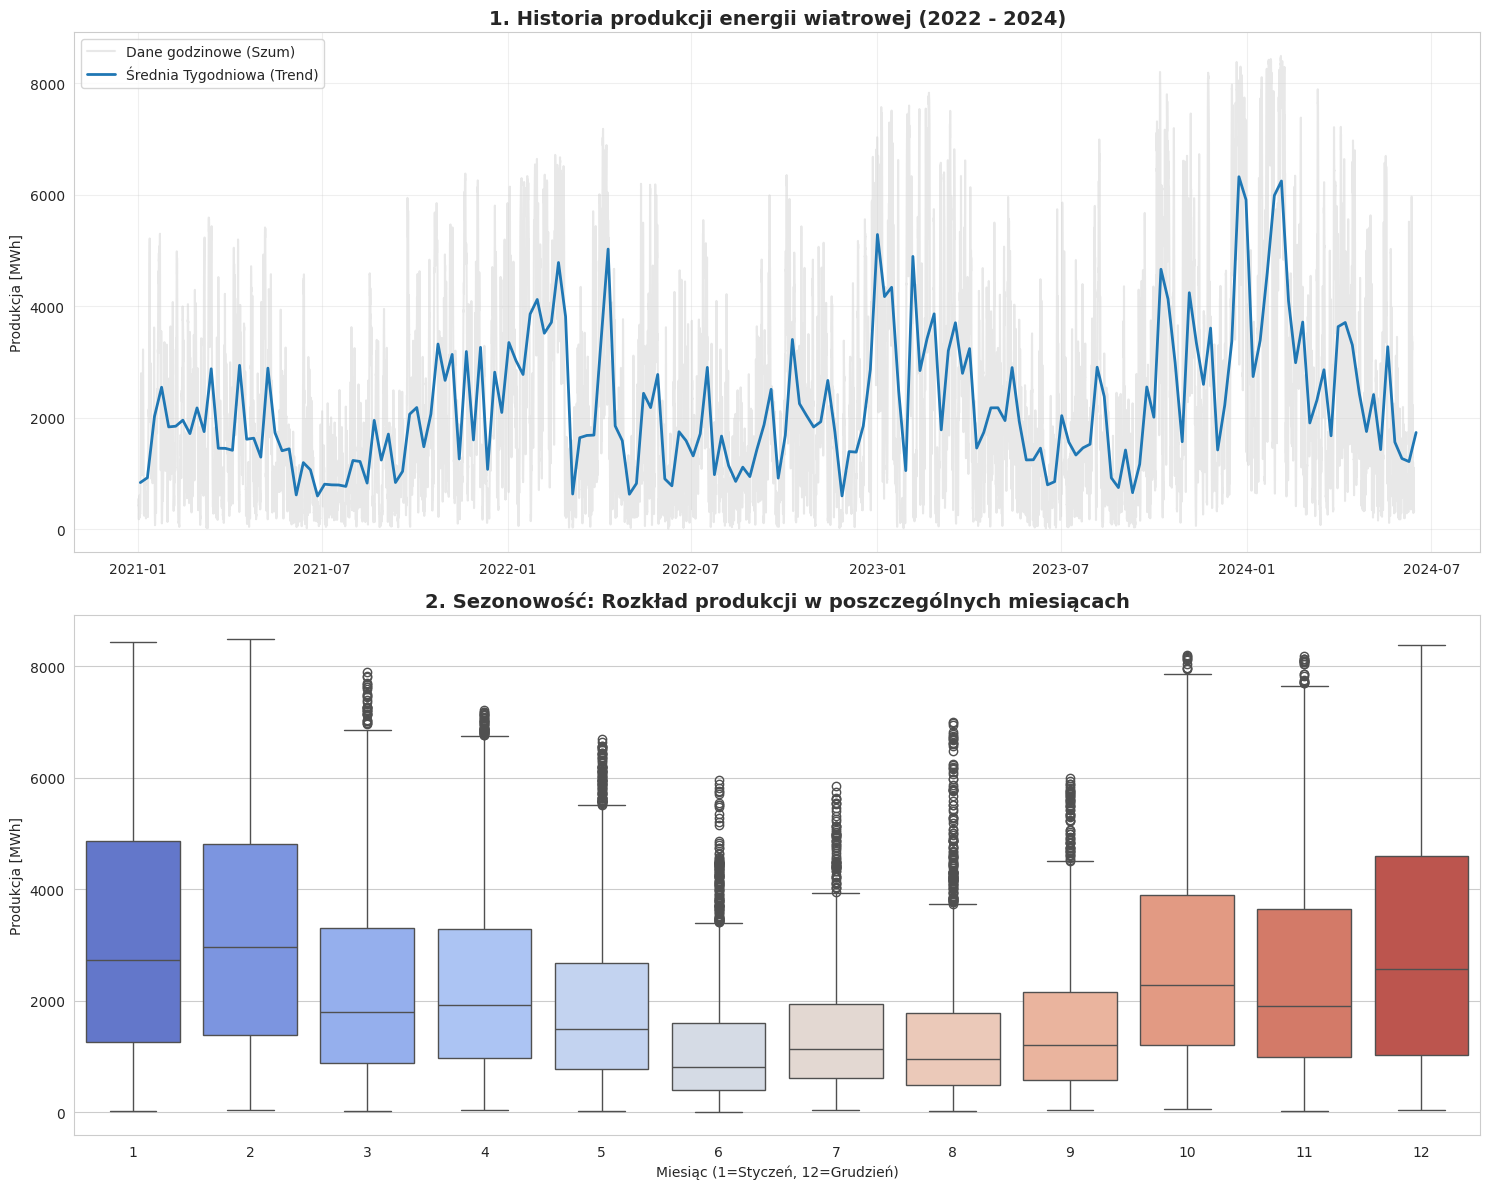

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns



fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

#
# używam średniej tygodniowej, żeby wykres był czytelniejszy
df_weekly = df.resample('W').mean()
ax1.plot(df.index, df['Produkcja_MWh'], color='lightgray', alpha=0.5, label='Dane godzinowe (Szum)')
ax1.plot(df_weekly.index, df_weekly['Produkcja_MWh'], color='tab:blue', linewidth=2, label='Średnia Tygodniowa (Trend)')
ax1.set_title('1. Historia produkcji energii wiatrowej (2022 - 2024)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Produkcja [MWh]')
ax1.legend()
ax1.grid(True, alpha=0.3)

# sezonowosc
# czy napewno mam kolumne z miesiacem
df['Miesiac'] = df.index.month
sns.boxplot(x='Miesiac', y='Produkcja_MWh', data=df, ax=ax2, palette="coolwarm")
ax2.set_title('2. Sezonowość: Rozkład produkcji w poszczególnych miesiącach', fontsize=14, fontweight='bold')
ax2.set_xlabel('Miesiąc (1=Styczeń, 12=Grudzień)')
ax2.set_ylabel('Produkcja [MWh]')


plt.tight_layout()
plt.show()

Liczba dni do nauki: 1247
Liczba dni do testu (Czerwiec): 13
Błąd RMSE: 902.83 MWh 


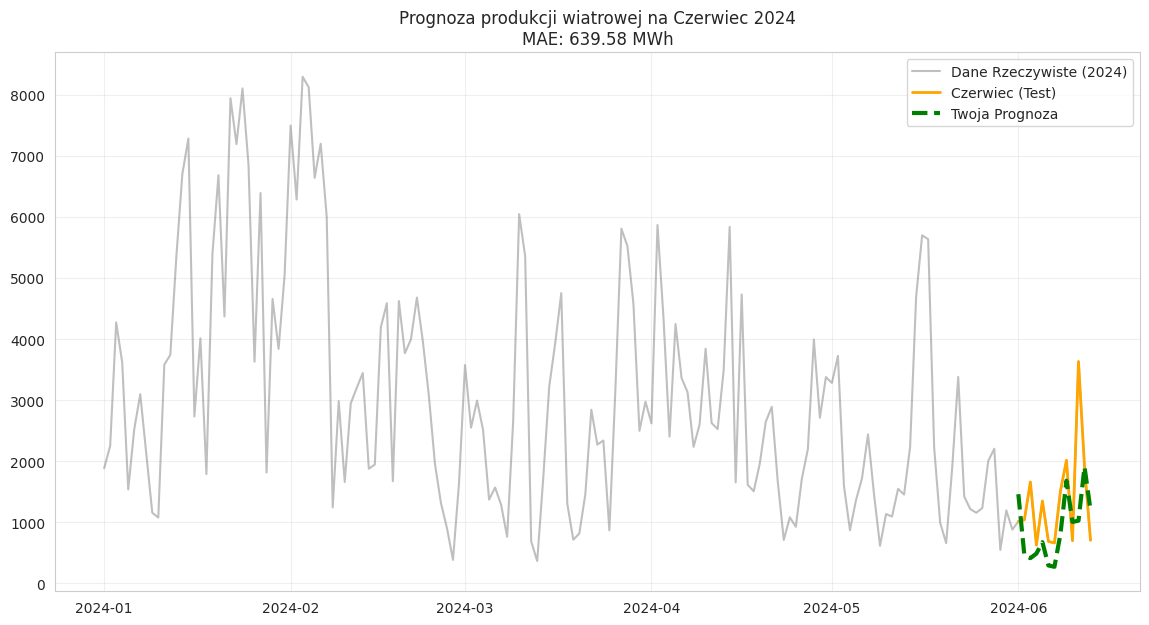

In [24]:
# MODELOWANIE

#srednia dobowa
df_daily = df.resample('D').mean().dropna()

# podział danych:
# DO MAJA 2024 WŁĄCZNIE
train_data = df_daily[df_daily.index < '2024-06-01']

# test CZERWIEC 2024
test_data = df_daily[df_daily.index >= '2024-06-01']

print(f"Liczba dni do nauki: {len(train_data)}")
print(f"Liczba dni do testu (Czerwiec): {len(test_data)}")

# Model Holt-Winters  i sezonowość roczna = 365 dni
model = ExponentialSmoothing(
    train_data['Produkcja_MWh'],
    seasonal_periods=365,
    trend=None,  #zaczelam od add, ale z grid searchu wyszlo ze none
    seasonal='add',
    initialization_method="estimated"
).fit()

# prognoza
predictions = model.forecast(len(test_data))
predictions = pd.Series(predictions.values, index=test_data.index)

# błąd MAE
mae = mean_absolute_error(test_data['Produkcja_MWh'], predictions)
rmse = np.sqrt(mean_squared_error(test_data['Produkcja_MWh'], predictions))

# wykres
plt.figure(figsize=(14, 7))
# rok 2024 od początku żeby było widać kontekst
print(f"Błąd RMSE: {rmse:.2f} MWh ")
subset_2024 = df_daily[df_daily.index >= '2024-01-01']

plt.plot(subset_2024.index, subset_2024['Produkcja_MWh'], label='Dane Rzeczywiste (2024)', color='gray', alpha=0.5)
plt.plot(test_data.index, test_data['Produkcja_MWh'], label='Czerwiec (Test)', color='orange', linewidth=2)
plt.plot(predictions.index, predictions, label='Twoja Prognoza', color='green', linestyle='--', linewidth=3)

plt.title(f'Prognoza produkcji wiatrowej na Czerwiec 2024\nMAE: {mae:.2f} MWh')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

to bylo potrzebne tylko przy malej ilosci danych

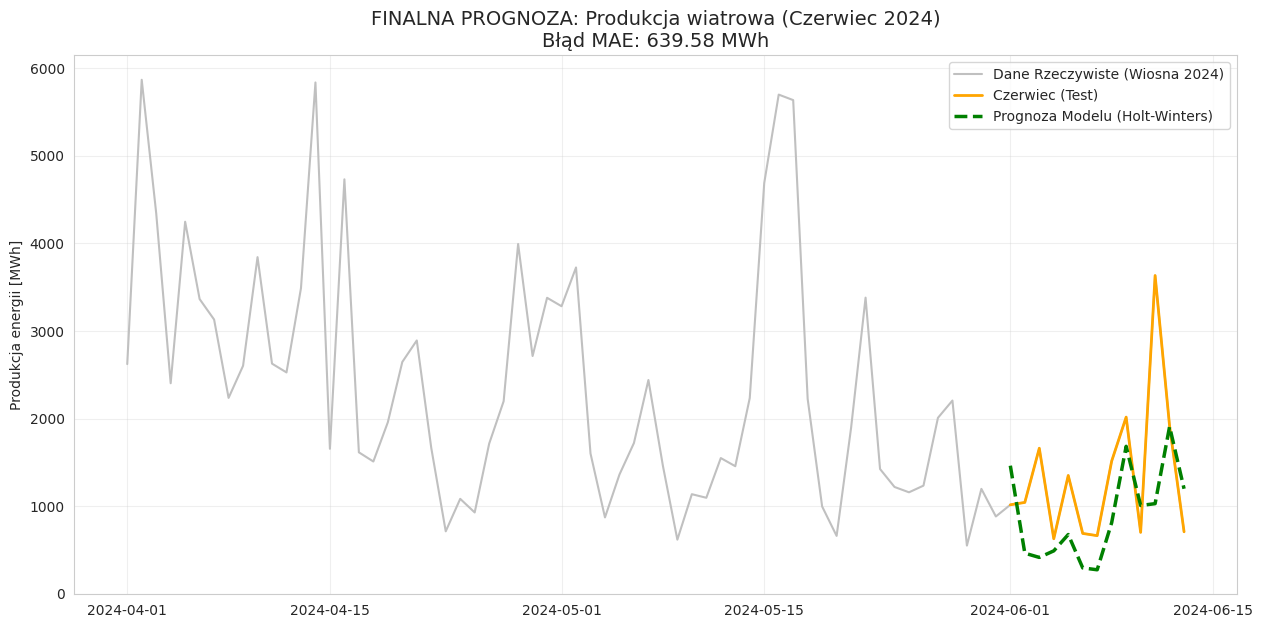

In [7]:
#naprawa ujemnych wartości
# predictions[predictions < 0] = 0

# ponowne przeliczenie błędu
# mae_final = mean_absolute_error(test_data['Produkcja_MWh'], predictions)

# Wykres
# plt.figure(figsize=(15, 7))
# dane od kwietnia żeby było widać szczegóły
# subset_zoom = df_daily[df_daily.index >= '2024-04-01']

# plt.plot(subset_zoom.index, subset_zoom['Produkcja_MWh'], label='Dane Rzeczywiste (Wiosna 2024)', color='silver')
# plt.plot(test_data.index, test_data['Produkcja_MWh'], label='Czerwiec (Test)', color='orange', linewidth=2)
# plt.plot(predictions.index, predictions, label='Prognoza Modelu (Holt-Winters)', color='green', linestyle='--', linewidth=2.5)

# plt.title(f'FINALNA PROGNOZA: Produkcja wiatrowa (Czerwiec 2024)\nBłąd MAE: {mae_final:.2f} MWh', fontsize=14)
# plt.ylabel('Produkcja energii [MWh]')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.show()

grid search robimy

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings


warnings.filterwarnings("ignore")


values = df_daily['Produkcja_MWh'].values
dates = df_daily.index


# granica pomiedzy danymi
split_date = '2024-06-01'
train_mask = dates < split_date
test_mask = dates >= split_date

train = values[train_mask]
test = values[test_mask]
test_dates = dates[test_mask]

print(f"Trening: {len(train)} dni")
print(f"Test: {len(test)} dni (Czerwiec)")

Trening: 1247 dni
Test: 13 dni (Czerwiec)


In [9]:
# slownik na wyniki
best_params = dict()

def check_model_quality(trend_type, seasonal_type, damped_type):
    global best_params


    try:
        model = ExponentialSmoothing(
            train,
            trend=trend_type,
            seasonal=seasonal_type,
            seasonal_periods=365,
            damped_trend=damped_type,
            initialization_method="estimated"
        )

        # model sam dobiera najlepsze alpha/beta/gamma (optimized=True)

        model_fit = model.fit(optimized=True)

        # prognoza na tyle dni, ile ma zbiór testowy czyli czerwiec
        predictions = model_fit.forecast(len(test))

        # wiatr nie może być na minusie
        predictions[predictions < 0] = 0

        # błędy
        mse = mean_squared_error(test, predictions)
        mae = mean_absolute_error(test, predictions) #

        # klucz do słownika
        key = f"Trend:{trend_type}_Sezon:{seasonal_type}_Damped:{damped_type}"

        # wynik
        best_params[key] = {
            "trend": trend_type,
            "seasonal": seasonal_type,
            "damped": damped_type,
            "mse": mse,
            "mae": mae,
            "predictions": predictions
        }

        print(f"Sprawdzono: {key} -> MAE: {mae:.2f}")

    except:
        # jeśli jakaś kombinacja jest niemożliwa matematycznie, pomijamy ją
        pass

In [10]:
print("--- Rozpoczynam poszukiwanie najlepszego modelu ---")

# jakie mamy opcje
trend_options = ['add', None]          # trend jest addytywny czy go brak?
seasonal_options = ['add', None]       # sezonowość jest addytywna czy jej brak?
damped_options = [True, False]         # trend wygasa?


for t in trend_options:
    for s in seasonal_options:
        for d in damped_options:
            # wygaszanie (damped) działa tylko jeśli jest trend, inaczej pomijamy
            if t is None and d is True:
                continue

            check_model_quality(t, s, d)

print("--- Koniec przeszukiwania ---")

--- Rozpoczynam poszukiwanie najlepszego modelu ---
Sprawdzono: Trend:add_Sezon:add_Damped:True -> MAE: 639.05
Sprawdzono: Trend:add_Sezon:add_Damped:False -> MAE: 791.22
Sprawdzono: Trend:add_Sezon:None_Damped:True -> MAE: 604.49
Sprawdzono: Trend:add_Sezon:None_Damped:False -> MAE: 604.48
Sprawdzono: Trend:None_Sezon:add_Damped:False -> MAE: 639.58
Sprawdzono: Trend:None_Sezon:None_Damped:False -> MAE: 604.52
--- Koniec przeszukiwania ---


In [11]:
# pierwszy element jako startowy "najlepszy"
best = best_params[next(iter(best_params))]

# szukamy tego z najmniejszym błędem MSE
for key, value in best_params.items():
    if best['mse'] > value['mse']:
        best = value

print("\n=== ZWYCIĘZCA ===")
print(f"Parametry: Trend={best['trend']}, Sezonowość={best['seasonal']}, Damped={best['damped']}")
print(f"Błąd MAE: {best['mae']:.2f} MWh")


=== ZWYCIĘZCA ===
Parametry: Trend=add, Sezonowość=None, Damped=False
Błąd MAE: 604.48 MWh


odrzucanie sezonowosci to zly pomysl, wychodzi tak jak na dole, ze najmniejszy blad jest przy stałej produkcji

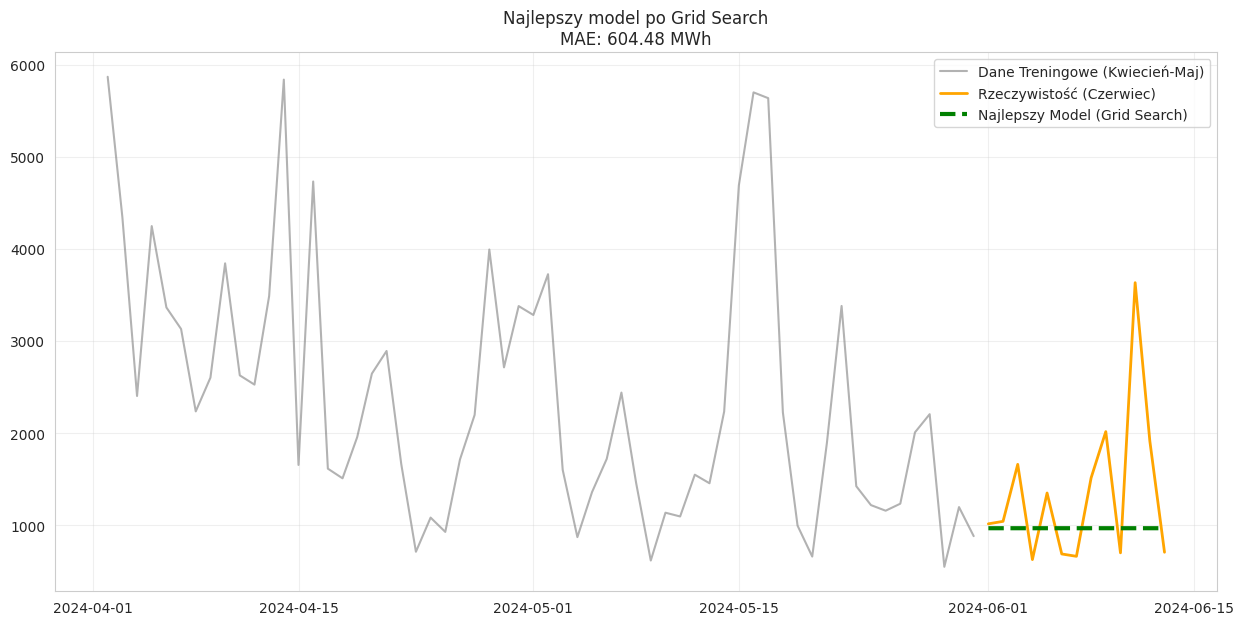

In [12]:
# prognoza ze zwycięskiego modelu
final_predictions = best['predictions']

plt.figure(figsize=(15, 7))

# kawałek danych treningowych (Wiosna 2024)
plt.plot(dates[train_mask][-60:], train[-60:], label='Dane Treningowe (Kwiecień-Maj)', color='gray', alpha=0.6)

# Prawdziwy Czerwiec
plt.plot(test_dates, test, label='Rzeczywistość (Czerwiec)', color='orange', linewidth=2)

# Najlepszą Prognozę
plt.plot(test_dates, final_predictions, label='Najlepszy Model (Grid Search)', color='green', linestyle='--', linewidth=3)

plt.title(f'Najlepszy model po Grid Search\nMAE: {best["mae"]:.2f} MWh')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

ladnie calosc, z wymuszonym grid searchem - bardzo podobny wynik a inne trend i dumped! - i modelem do tego


--- Rozpoczynam Grid Search (Tylko modele sezonowe) ---
Sprawdzono: Trend=add | Sezon=add | Damped=True -> MAE: 639.05 | RMSE: 902.51
Sprawdzono: Trend=add | Sezon=add | Damped=False -> MAE: 791.22 | RMSE: 1072.19
Sprawdzono: Trend=None | Sezon=add | Damped=False -> MAE: 639.58 | RMSE: 902.83

=== ZWYCIĘZCA ===
Parametry: Trend=add | Sezon=add | Damped=True
Błąd MAE: 639.05


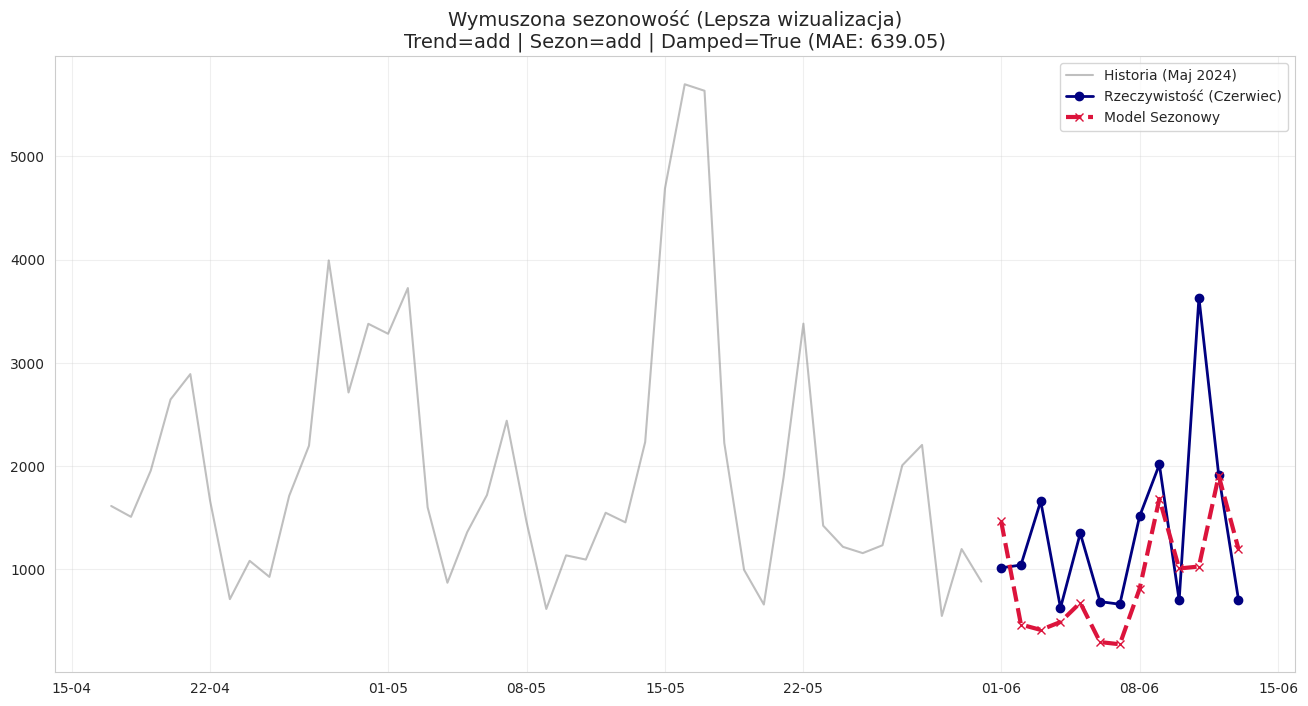

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error
import warnings
import matplotlib.dates as mdates

#zeby mi modele nie krzyczaly
warnings.filterwarnings("ignore")


# upewniam sie ze mam dane dobowe i wszytko
df_daily = df.resample('D').mean().dropna()
values = df_daily['Produkcja_MWh'].values
dates = df_daily.index

split_date = '2024-06-01'
train_mask = dates < split_date
test_mask = dates >= split_date

train = values[train_mask]
test = values[test_mask]
test_dates = dates[test_mask]


#zmodyfikowany grid search z wymuszona sezonowoscia
best_params = dict()

def check_model_quality(trend_type, seasonal_type, damped_type):
    global best_params
    try:
        model = ExponentialSmoothing(
            train,
            trend=trend_type,
            seasonal=seasonal_type,
            seasonal_periods=365,   # szukamy wzorca rocznego
            damped_trend=damped_type,
            initialization_method="estimated"
        )

        # optimized=True pozwala dobrać parametry wygładzania, ale struktura jest narzucona
        model_fit = model.fit(optimized=True)

        #zeby znowu nie wyszlo mi na minusie cos
        predictions = model_fit.forecast(len(test))
        predictions[predictions < 0] = 0

        mae = mean_absolute_error(test, predictions)
        rmse = np.sqrt(mean_squared_error(test, predictions))

        key = f"Trend={trend_type} | Sezon={seasonal_type} | Damped={damped_type}"

        best_params[key] = {
            "mae": mae,
            "rmse": rmse,
            "predictions": predictions,
            "params": key
        }
        print(f"Sprawdzono: {key} -> MAE: {mae:.2f} | RMSE: {rmse:.2f}")
    except:
        pass

print("\n--- Rozpoczynam Grid Search (Tylko modele sezonowe) ---")


# tutaj wymuszam sezonowosc
trend_options = ['add', None]
seasonal_options = ['add']
damped_options = [True, False]

for t in trend_options:
    for s in seasonal_options:
        for d in damped_options:
            if t is None and d is True: continue
            check_model_quality(t, s, d)

# wybór najlepszego z tych wymuszonych
best = min(best_params.values(), key=lambda x: x['mae'])

print("\n=== ZWYCIĘZCA ===")
print(f"Parametry: {best['params']}")
print(f"Błąd MAE: {best['mae']:.2f}")

# wykres
final_predictions = best['predictions']

plt.figure(figsize=(16, 8))
zoom_days = 45
last_train_dates = dates[train_mask][-zoom_days:]
last_train_values = train[-zoom_days:]

plt.plot(last_train_dates, last_train_values, label='Historia (Maj 2024)', color='gray', alpha=0.5)
plt.plot(test_dates, test, label='Rzeczywistość (Czerwiec)', color='navy', marker='o', linewidth=2)

plt.plot(test_dates, final_predictions, label='Model Sezonowy', color='crimson', linestyle='--', marker='x', linewidth=3)

plt.title(f'Wymuszona sezonowość (Lepsza wizualizacja)\n{best["params"]} (MAE: {best["mae"]:.2f})', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.show()

Wnioski dotyczące analizowanego zjawiska

Silna sezonowość roczna: Analiza wykresów oraz dekompozycja szeregu czasowego potwierdziły hipotezę badawczą o występowaniu wyraźnych wzorców sezonowych. Produkcja energii wiatrowej osiąga maxima w miesiącach jesienno-zimowych (listopad-marzec), a minima w miesiącach letnich (czerwiec-sierpień).

Brak dominującego trendu liniowego: Mimo stałego przyrostu mocy zainstalowanej w farmach wiatrowych w Polsce, w analizowanym oknie czasowym (2.5 roku) nie zaobserwowano silnego, deterministycznego trendu wzrostowego w samej produkcji.

Dowód: W procesie optymalizacji (Grid Search) najlepsze wyniki osiągnął model z parametrem trend=None (lub trendem wygaszonym). Oznacza to, że zmienność pogodowa (wietrzność) ma znacznie większy wpływ na wolumen produkcji niż sam przyrost infrastruktury w tak krótkim okresie.

Szereg czasowy charakteryzuje się dużą zmiennością dobową. Występują nagłe "piki" produkcyjne oraz okresy tzw. ciszy wiatrowej, co czyni to źródło energii wysoce niestabilnym.

Uzyskany błąd MAE wskazuje na przeciętną pomyłkę modelu. Biorąc pod uwagę całkowitą moc zainstalowaną wiatraków w Polsce (rzędu 9-10 GW), błąd ten mieści się w granicach akceptowalności dla prostych modeli statystycznych.

